In [1]:
import os as os
import pandas as pd
import numpy as np
from matplotlib import pyplot



In [2]:
reportsPath =  os.path.abspath("..\\bin\\Debug\\netcoreapp3.1\\reports\\countries")


In [3]:
countries_list = ["Italy", "Russia", "Germany"]

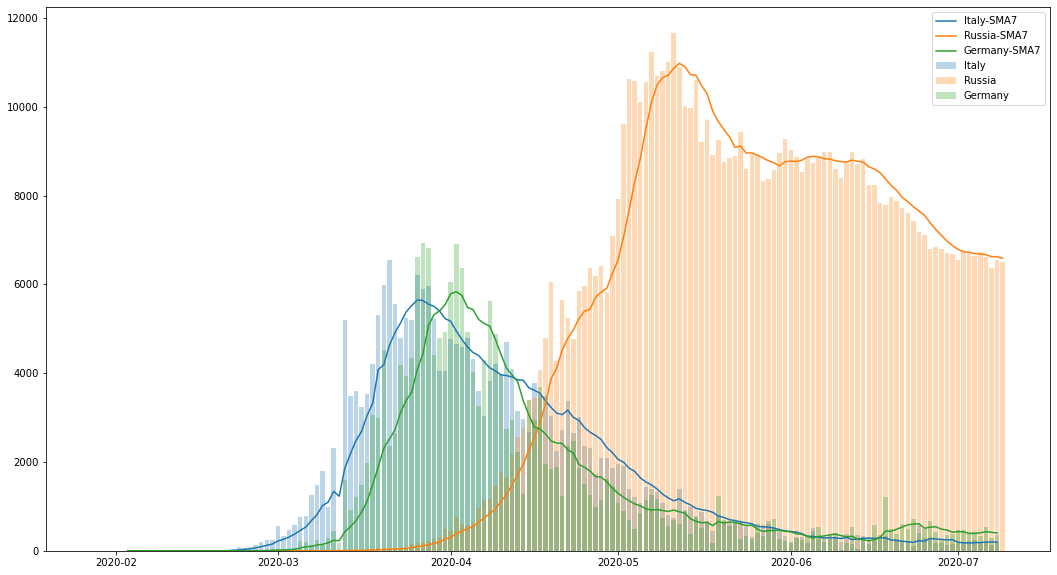

In [4]:

pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)
ax.xaxis_date()

for country in countries_list:
    report_file = os.path.join(reportsPath,country,country+".csv")
    country_df = pd.read_csv(report_file, parse_dates=["Date"], index_col = "Date", dayfirst=True)
    country_df['Confirmed_Change_SMA7'] = country_df['Confirmed_Change'].rolling(window=7).mean()

    ax.bar(country_df.index, country_df['Confirmed_Change'].values, label=country, alpha=0.3)
    ax.plot(country_df.index, country_df['Confirmed_Change_SMA7'].values, label=country + '-SMA7') 

ax.set_ylim(bottom=0)
ax.legend()
pyplot.show()


In [58]:
russiaRegions = os.path.join(reportsPath,"Russia\\regions")
region_dfs = {}
for region_report in os.listdir(russiaRegions):
    region_report_path = os.path.join(russiaRegions, region_report)
    region_df = pd.read_csv(region_report_path, parse_dates=["Date"], index_col = "Date", dayfirst=True)
    region_dfs[os.path.splitext(region_report)[0]] = region_df.iloc[58:]

In [59]:
moscow_df = region_dfs.pop("Москва")

In [66]:
column_name = "Active"

regions_df = pd.DataFrame()

for region, region_df in region_dfs.items():
    regions_df[region] = region_dfs[region][column_name]

regions_df.head()

,Адыгея,Алтай,Алтайский край,Амурская обл.,Архангельская обл.,Астраханская обл.,Башкортостан,Белгородская обл.,Брянская обл.,Бурятия,...,Ульяновская обл.,Хабаровский край,Хакасия,ХМАО – Югра,Челябинская обл.,Чечня,Чувашия,Чукотский АО,Ямало-Ненецкий АО,Ярославская обл.
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-29,1,0,0,1,3,0,5,2,3,8,...,1,7,2,5,12,9,1,0,0,3
2020-03-30,4,0,1,1,7,0,5,5,3,13,...,1,7,3,5,14,9,1,0,0,3
2020-03-31,4,0,2,1,7,2,7,5,3,19,...,1,8,3,5,14,9,1,0,0,2
2020-04-01,4,0,3,1,7,2,7,5,5,25,...,1,9,3,8,21,10,1,0,0,2
2020-04-02,5,0,4,1,7,2,9,6,5,30,...,1,9,3,8,19,9,1,0,2,2


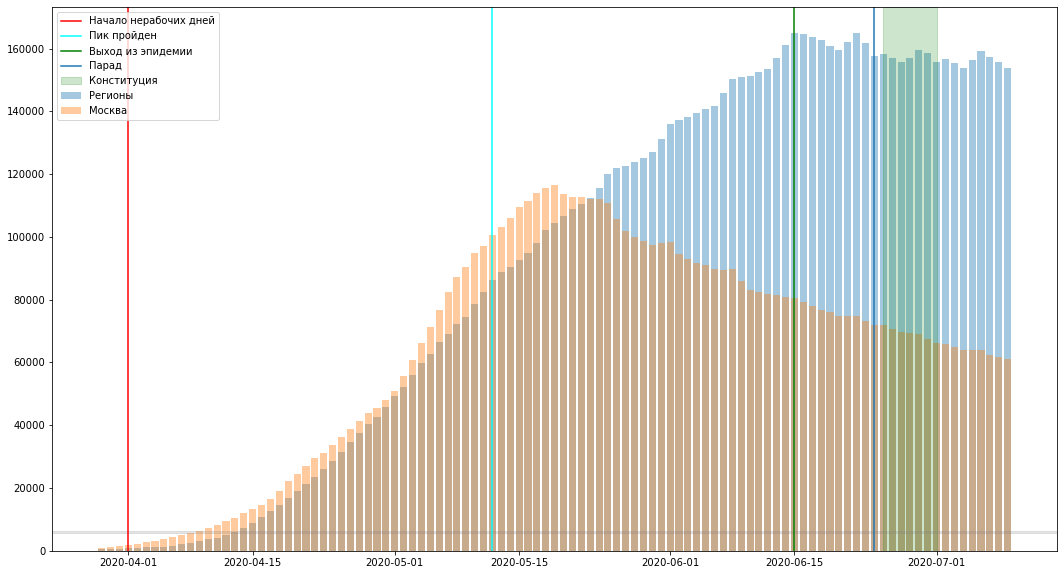

In [67]:
pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)
ax.xaxis_date()

regions_df['Total'] = 0
regions_df['Total'] = regions_df.sum(axis = 1)

ax.bar(regions_df.index, regions_df['Total'].values, label = 'Регионы', alpha=0.4)
ax.bar(moscow_df.index, moscow_df[column_name].values, label = 'Москва', alpha = 0.4)

ax.axvline(pd.to_datetime('01-04-2020', dayfirst=True), label = 'Начало нерабочих дней', color = 'Red')
ax.axvline(pd.to_datetime('12-05-2020', dayfirst=True), label = 'Пик пройден', color = 'Cyan')
ax.axvline(pd.to_datetime('15-06-2020', dayfirst=True), label = 'Выход из эпидемии', color = 'Green')
ax.axvline(pd.to_datetime('24-06-2020', dayfirst=True), label = 'Парад')
ax.axvspan(pd.to_datetime('25-06-2020', dayfirst=True), pd.to_datetime('01-07-2020', dayfirst=True), label='Конституция', alpha = 0.2, color = 'Green')
ax.axhspan(5800, 6200, alpha = 0.2, color = 'Grey')

#ax.set_ylim(bottom=5000, top = 6500)
ax.legend()
pyplot.show()